In [1]:
from imports import *
from datasets.bdd_oia import BDD_OIA

In [2]:
image_home = './data/bdd_oia/lastframe/data/'
label_home = './data/bdd_oia/lastframe/labels/'


In [3]:
# labels = pd.read_csv(label_home+'no_train.csv')
labels = pd.read_pickle(label_home+'no_train.pkl')
labels.head(3)

,file_name,reason,action,reason_lang,reason_lang_ind
2075,b82609d8-eef37c99_3.jpg,"[0, 1, 0, 1, 0, 0]","[1, 0, 0, 0]",no lane on the left;obstacles on the rightlane,"[3, 7, 4, 9, 13, 5, 1, 8, 9, 13, 11, 2]"
2078,af1425f4-892440e1_3.jpg,"[0, 1, 0, 0, 0, 0]","[1, 0, 0, 1]",no lane on the left,"[3, 7, 4, 9, 13, 5, 2]"
2365,047e732b-aa79a87d.jpg,"[0, 1, 0, 0, 1, 0]","[1, 0, 0, 0]",no lane on the left;no lane on the right,"[3, 7, 4, 9, 13, 5, 1, 7, 4, 9, 13, 10, 2]"


In [4]:
test_img_name = labels.iloc[0]['file_name']
test_img = Image.open(image_home+test_img_name)

In [5]:
import torchvision.transforms as T
mean=[102.9801, 115.9465, 122.7717]
std=[1., 1., 1.]

transform = T.Compose([T.ToTensor(),T.Normalize(mean,std)])

In [6]:
class BDD_OIA_NLP(Dataset):
    def __init__(self, image_root, label_root, ind_to_word_root, image_min_size=120):
        super().__init__()
        import torchvision.transforms as T

        self.image_root = image_root
        self.mean=[102.9801, 115.9465, 122.7717]
        self.std=[1., 1., 1.]

        self._processing(label_root,ind_to_word_root)

        self.transform = T.Compose([T.Resize(image_min_size),
                                    T.ToTensor(),
                                #    T.Normalize(self.mean,self.std),
                                    ])

    def _processing(self, label_root, ind_to_word_root):
        data_df = pd.read_pickle(label_root)

        self.count = len(data_df)
        self.all_images = data_df['file_name']
        self.all_reasons = data_df['reason_lang_ind']
        self.all_actions = data_df['action']
        print("number of samples in dataset:{}".format(self.count))

        with open(ind_to_word_root,'rb') as f:
            self.ind_to_word = pickle.load(f)

        self.word_to_ind = dict([(value, key) for key, value in self.ind_to_word.items()]) 

        self.num_words = len(self.ind_to_word.keys())

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        # test = True
        target = {}
        image_name = self.all_images.iloc[idx]

        # print(type(self.all_actions[idx]))
        target['action'] = torch.tensor(self.all_actions.iloc[idx][:4])
        target['reason'] = torch.tensor(self.all_reasons.iloc[idx])

        img_ = Image.open(self.image_root + image_name)

        img = self.transform(img_)

        return img,target

image_dir = './data/bdd_oia/lastframe/data/'
label_dir = './data/bdd_oia/lastframe/labels/'
bdd_oia_dataset = BDD_OIA_NLP(image_dir, label_dir+'no_train.pkl', label_dir+'ind_to_word.pkl',image_min_size=180)

training_loader = DataLoader(bdd_oia_dataset,
                            shuffle=True,
                            batch_size=10,
                            num_workers=0,
                            drop_last=True,
                            collate_fn=utils.collate_fn)
images_batch,labels_batch = next(iter(training_loader))
images_batch = torch.stack(images_batch)
images_batch.shape

number of samples in dataset:19936


torch.Size([10, 3, 180, 320])

In [7]:
resnet = torchvision.models.resnet50(pretrained=True)

mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

In [8]:
from torchsummary import summary

# summary(resnet,(3,180,320))

In [9]:
feature_extractor_mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

In [10]:
image_feature = feature_extractor_mobilenet(images_batch)
image_feature.shape

torch.Size([10, 1280, 6, 10])

## Language Model

In [11]:
reason_batch = [l['reason'] for l in labels_batch]
reason_batch

[tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3, 12,  9, 13,  5,  1,  7,  4,  9, 13, 10,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  8,  9, 13, 11,  2]),
 tensor([ 3, 12,  9, 13,  5,  1, 12,  9, 13, 10,  2]),
 tensor([ 3,  8,  9, 13,  6,  2]),
 tensor([ 3, 12,  9, 13,  5,  1,  8,  9, 13, 11,  2])]

In [76]:
class ReasonDecoder(nn.Module):
    def __init__(self, image_f_dim, embedding_dim, hidden_dim, dict_size, device='cpu', null_index=0, start_index = 3, end_index=2,using_gate=True):
        super().__init__()
        self._NULL_INDEX = null_index
        self._START_INDEX = start_index
        self._DICT_SIZE = dict_size
        self._END_INDEX = end_index

        self._hidden_dim = hidden_dim
        self._embedding_dim = embedding_dim
        self._image_f_dim = image_f_dim
        
        self.using_gate = using_gate
        self.device = device
        
        self.embedding_layer = nn.Embedding(num_embeddings=self._DICT_SIZE,embedding_dim=self._embedding_dim)
        self.image_affine_layers = nn.Sequential(nn.Linear(self._image_f_dim,self._hidden_dim),nn.ReLU()) 
        self.init_c_layer = nn.Linear(self._hidden_dim,self._hidden_dim)
        self.init_h_layer = nn.Linear(self._hidden_dim,self._hidden_dim)
        self.lstm_step = nn.LSTMCell(input_size=hidden_dim*2,hidden_size=hidden_dim)
        self.score_layer = nn.Linear(hidden_dim, self._DICT_SIZE)      
        if self.using_gate:
            self.gate = nn.Sequential(nn.Linear(self._hidden_dim, self._hidden_dim), nn.Sigmoid())
        self.loss = self.loss_fn()

    def loss_fn(self):
        reason_loss = nn.CrossEntropyLoss().to(self.device)
        return reason_loss

    def dot_product_attention(self, prev_h, A):
        """
        dot product between the hidden state and image embeddings
        A: B,F,H,W
        prev_h: B,F
        
        (F: hidden dimension)
        """
        B,F,H,W = A.shape
        attention_score = torch.bmm(prev_h.view(B,1,F),A.view(B,F,H*W)).squeeze(1).div(F**0.5) # B, H*W
        attention_weights = nn.functional.softmax(attention_score,dim=1) # B, H*W
        attended_features = torch.bmm(A.view(B,F,H*W), attention_weights.view(B,H*W,1)).squeeze(2) # B, F
        attention_weights = attention_weights.view(B,H,W)

        return attention_weights, attended_features

    def init_hidden_state(self, A):
        mean_image = A.mean(dim=(2,3)) # N,image_feature_dim
        h0 = self.init_h_layer(mean_image)
        c0 = self.init_c_layer(mean_image)
        return h0, c0   

    def forward(self, image_feature, reason_batch):

        image_f = self.image_affine_layers(image_feature.permute(0,2,3,1)).permute(0,3,1,2) # B , F , H , W 

        ## Manipulate the reason batch
        padded = nn.utils.rnn.pad_sequence(reason_batch,padding_value=self._NULL_INDEX)
        embedded = self.embedding_layer(padded)
        embedded_input = embedded[:-1,:,:]
        padded_output = padded[1:,:]
        T,B,E = embedded_input.shape
        
        h,c = self.init_hidden_state(image_f)
        
        hs = []
        scores = []
        attention_weights = []
        
        for t in range(T):
            attention_weight, attended_features = self.dot_product_attention(h,image_f)
            # print(attended_feature.shape)
            if self.using_gate:
                gate_val = self.gate(h)
                # print(gate_val.shape)
                attended_features = attended_features*gate_val
            
            lstm_input = torch.cat([attended_features,embedded_input[t]],axis=1)
            h,c = self.lstm_step(lstm_input,(h,c))
            score = self.score_layer(h)
            hs.append(h)
            scores.append(score)
            attention_weights.append(attention_weight)
        hs, scores, attention_weights = torch.stack(hs), torch.stack(scores) ,torch.stack(attention_weights) 

        if self.training:
            loss = self.loss(scores.view(-1,self._DICT_SIZE), padded_output.view(-1))
            return loss,scores, attention_weights, hs
        else:
            return scores, attention_weights, hs #hs: T B F, attention weights: T, B, H, W 
    
    def generate_reason(self, image_feature, max_length=33):
        image_f = self.image_affine_layers(image_feature.permute(0,2,3,1)).permute(0,3,1,2) # B , F , H , W 

        B = image_f.shape[0]
        
        prev_word = torch.LongTensor([self._START_INDEX]*B).to(self.device)

        h0,c0 = self.init_hidden_state(image_f)
        h = h0
        c = c0
        hs = []
        scores = []
        attention_weights = []
        reasons = []
        
        for t in range(max_length):
            prev_embedding = self.embedding_layer(prev_word)
            attention_weight, attended_features = self.dot_product_attention(h,image_f)
            # print(attended_feature.shape)
            if self.using_gate:
                gate_val = self.gate(h)
                # print(gate_val.shape)
                attended_features = attended_features*gate_val
            
            lstm_input = torch.cat([attended_features,prev_embedding],axis=1)
            h,c = self.lstm_step(lstm_input,(h,c))
            score = self.score_layer(h)
            prev_word = torch.max(score,1)[1]
            hs.append(h)
            scores.append(score)
            attention_weights.append(attention_weight)
            reasons.append(prev_word)
        hs, scores, attention_weights, reasons = torch.stack(hs), torch.stack(scores),torch.stack(attention_weights),torch.stack(reasons) 

        return hs, scores, attention_weights, reasons


In [77]:
NULL_INDEX = bdd_oia_dataset.word_to_ind['NULL']
DICT_SIZE = len(bdd_oia_dataset.word_to_ind.keys())


reason_decoder = ReasonDecoder(image_f_dim=1280,\
                               embedding_dim=128, \
                               hidden_dim=128, \
                               dict_size=DICT_SIZE, \
                               device='cpu',\
                               null_index=NULL_INDEX, \
                               using_gate=True)

# reason_decoder.train()
loss, scores, attention_weights, hs = reason_decoder(image_feature,reason_batch)

In [61]:
NULL_INDEX = bdd_oia_dataset.word_to_ind['NULL']
DICT_SIZE = len(bdd_oia_dataset.word_to_ind.keys())
padded = nn.utils.rnn.pad_sequence(reason_batch,padding_value=NULL_INDEX)
padded.shape

torch.Size([12, 10])

In [62]:
embedding_size = 128
embedding_layer = nn.Embedding(num_embeddings=DICT_SIZE,embedding_dim=embedding_size)
embedded = embedding_layer(padded)


In [63]:
embedded.shape

torch.Size([12, 10, 128])

In [64]:
image_affine_layers = nn.Sequential(nn.Linear(1280,128),
                                    nn.ReLU()) 

image_f = image_affine_layers(image_feature.permute(0,2,3,1)).permute(0,3,1,2) # B , F , H , W 
image_f.shape


torch.Size([10, 128, 6, 10])

In [65]:
def dot_product_attention(prev_h, A):
    """
    dot product between the hidden state and image embeddings
    A: B,F,H,W
    prev_h: B,F
    """
    B,F,H,W = A.shape
    attention_score = torch.bmm(prev_h.view(B,1,F),A.view(B,F,H*W)).squeeze(1).div(F**0.5) # B, H*W
    attention_weights = nn.functional.softmax(attention_score,dim=1) # B, H*W

    attended_features = torch.bmm(A.view(B,F,H*W), attention_weights.view(B,H*W,1)).squeeze(2) # B, F
    
    attention_weights = attention_weights.view(B,H,W)

    return attention_weights, attended_features


In [66]:
image_feature_dim = 128
hidden_dim = 128
init_c_layer = nn.Linear(image_feature_dim,hidden_dim)
init_h_layer = nn.Linear(image_feature_dim,hidden_dim)

def init_hidden_state(A):
    mean_image = A.mean(dim=(2,3)) # N,image_feature_dim
    h0 = init_h_layer(mean_image)
    c0 = init_c_layer(mean_image)
    return h0, c0

h0,c0 = init_hidden_state(image_f)

attention_weights, attended_features = dot_product_attention(h0,image_f)
attention_weights.shape,attended_features.shape

(torch.Size([10, 6, 10]), torch.Size([10, 128]))

In [67]:
torch.cat([attended_features,attended_features],axis=1).shape

torch.Size([10, 256])

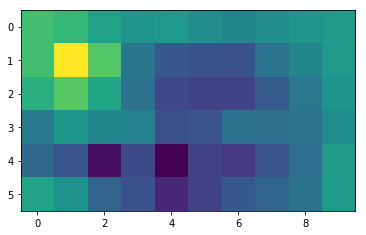

In [68]:
plt.imshow(attention_weights[3,:,:].detach().numpy())

In [69]:
hidden_dim = 128
lstm_step = nn.LSTMCell(input_size=hidden_dim*2,hidden_size=hidden_dim)
score_layer = nn.Linear(hidden_dim, DICT_SIZE)

In [70]:
max_seq_length = 33 
hs = []
scores = []
attention_weights = []

embedded_input = embedded[:-1,:,:]
embedded_output = embedded[1:,:,:]

T,B,E = embedded_output.shape
h = h0
c = c0
for t in range(T):
    attention_weight, attended_feature = dot_product_attention(h,image_f)
    lstm_input = torch.cat([attended_features,embedded[t]],axis=1)
    h,c = lstm_step(lstm_input,(h,c))
    score = prob_layer(h)
    hs.append(h)
    scores.append(score)
    attention_weights.append(attention_weight)

hs, scores, attention_weights, = torch.stack(hs), torch.stack(scores) ,torch.stack(attention_weights) #hs: T B F, attention weights: T, B, H, W 

NameError: name 'prob_layer' is not defined

torch.Size([11, 10, 128])

In [43]:
loss = nn.CrossEntropyLoss(ignore_index=NULL_INDEX)

In [45]:
loss(scores.view(-1,DICT_SIZE),padded.view(-1))

tensor(2.6376, grad_fn=<NllLossBackward>)

In [46]:
scores.view(-1,DICT_SIZE)

tensor([[0.0842, 0.0628, 0.0739,  ..., 0.0633, 0.0718, 0.0813],
        [0.0847, 0.0637, 0.0740,  ..., 0.0626, 0.0707, 0.0817],
        [0.0856, 0.0631, 0.0736,  ..., 0.0612, 0.0726, 0.0778],
        ...,
        [0.0726, 0.0764, 0.0686,  ..., 0.0682, 0.0759, 0.0849],
        [0.0699, 0.0779, 0.0670,  ..., 0.0693, 0.0756, 0.0873],
        [0.0657, 0.0797, 0.0710,  ..., 0.0714, 0.0743, 0.0875]],
       grad_fn=<ViewBackward>)

## Evaluation

In [20]:
def get_encoder():
    mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
    encoder = nn.Sequential(*list(mobilenet.children())[:-1])
    return encoder

encoder = get_encoder()

decoder = ReasonDecoder(image_f_dim=1280,\
                        embedding_dim=128, \
                        hidden_dim=128, \
                        dict_size=DICT_SIZE, \
                        device='cpu',\
                        null_index=NULL_INDEX, \
                        using_gate=True)

In [21]:
checkpoint = torch.load('./saved_models/soft_attention/soft_attention14.pth')

In [22]:
checkpoint.keys()

dict_keys(['encoder', 'decoder', 'decoder_optimizer'])

In [24]:
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

ReasonDecoder(
  (embedding_layer): Embedding(14, 128)
  (image_affine_layers): Sequential(
    (0): Linear(in_features=1280, out_features=128, bias=True)
    (1): ReLU()
  )
  (init_c_layer): Linear(in_features=128, out_features=128, bias=True)
  (init_h_layer): Linear(in_features=128, out_features=128, bias=True)
  (lstm_step): LSTMCell(256, 128)
  (score_layer): Linear(in_features=128, out_features=14, bias=True)
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (loss): CrossEntropyLoss()
)

In [ ]:
def generate_reason(image_feature, max_length=33):

    h = h0
    c = c0
    hs = []
    scores = []
    attention_weights = []
    
    for t in range(max_length):
        attention_weight, attended_features = decoder.dot_product_attention(h,image_f)
        # print(attended_feature.shape)
        if decoder.using_gate:
            gate_val = decoder.gate(h)
            # print(gate_val.shape)
            attended_features = attended_features*gate_val
        
        lstm_input = torch.cat([attended_features,embedded[t]],axis=1)
        h,c = decoder.lstm_step(lstm_input,(h,c))
        score = decoder.score_layer(h)
        hs.append(h)
        scores.append(score)
        attention_weights.append(attention_weight)
    hs, scores, attention_weights = torch.stack(hs), torch.stack(scores) ,torch.stack(attention_weights)

    return hs,scores, attention_weights 

In [46]:
device = 'cpu'

image_f = decoder.image_affine_layers(image_feature.permute(0,2,3,1)).permute(0,3,1,2) # B , F , H , W 
h0,c0 = decoder.init_hidden_state(image_f)
prev_word = torch.LongTensor([3]*10).to(device) # start tensor
prev_embedding = decoder.embedding_layer(prev_word)
prev_embedding.shape

torch.Size([10, 128])

In [58]:
h = h0
c = c0
hs = []
scores = []
attention_weights = []
reasons = []
max_length = 33
for t in range(max_length):
    prev_embedding = decoder.embedding_layer(prev_word)
    attention_weight, attended_features = decoder.dot_product_attention(h,image_f)
    # print(attended_feature.shape)
    if decoder.using_gate:
        gate_val = decoder.gate(h)
        # print(gate_val.shape)
        attended_features = attended_features*gate_val
    
    lstm_input = torch.cat([attended_features,prev_embedding],axis=1)
    h,c = decoder.lstm_step(lstm_input,(h,c))
    score = decoder.score_layer(h)
    prev_word = torch.max(score,1)[1]
    
    hs.append(h)
    scores.append(score)
    attention_weights.append(attention_weight)
    reasons.append(prev_word)
hs, scores, attention_weights, reasons = torch.stack(hs), torch.stack(scores),torch.stack(attention_weights),torch.stack(reasons)


In [59]:
reasons.shape
hs.shape

torch.Size([33, 10, 128])

In [60]:
reasons

tensor([[ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 8,  8, 12,  3, 12,  3,  3,  8,  3,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],
        [ 8,  8, 12,  3, 12,  3,  8,  8,  8,  3],


In [47]:
score.shape

torch.Size([10, 14])

In [51]:
torch.max(score,1)

torch.return_types.max(
values=tensor([3.4582, 3.3726, 3.5543, 4.3924, 2.9804, 4.4230, 3.9803, 3.2614, 4.1859,
        4.1699], grad_fn=<MaxBackward0>),
indices=tensor([ 3,  3,  3,  3, 12,  3,  3,  3,  3,  3]))